In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *

In [3]:
from src.networks import *

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [9]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')
args['exp_id'] = '81.1-resnet_d3_dr_0.1.yml'

In [7]:
f"{args['model_save_dir']}/{args['exp_id']}.h5"

'/home/rasp/data/myWeatherBench/predictions/saved_models//81.1-resnet_d3_dr_0.1.yml.h5'

In [9]:
model = keras.models.load_model(
    '/home/rasp/data/myWeatherBench/predictions/saved_models//81.1-resnet_d3_dr_0.1.h5', 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})

In [10]:
args['train_years'] = ['2014', '2015']

In [11]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [12]:
dg_train, dg_valid, dg_test = load_data(**args)

## Continuous time

In [45]:
X, y = dg_train[0]

In [46]:
X[:, 0, 0, -1]

array([1.66, 1.12, 0.56, 1.34, 0.36, 0.92, 0.46, 1.4 , 1.7 , 1.86, 0.72,
       0.08, 1.52, 1.6 , 1.76, 0.26, 0.06, 0.48, 1.22, 0.38, 0.06, 1.44,
       1.08, 0.7 , 0.8 , 1.12, 1.2 , 0.34, 0.6 , 0.82, 0.2 , 1.86],
      dtype=float32)

In [9]:
dg_train.data

<xarray.DataArray 'z' (time: 8760, lat: 32, lon: 64, level: 38)>
array([[[[ 0.43167361, -0.77058204, -0.91708119, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.43111803, -0.76282004, -0.90433586, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.43111803, -0.75625012, -0.89355009, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.43445417, -0.80103756, -0.95531952, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.433343  , -0.78969222, -0.94257419, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.43222919, -0.77954038, -0.92982769, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.41999842, -0.90912588, -1.08180004, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.41555111, -0.87329536, -1.03081639, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.40887882, -0.84045142, -0.9759101 , ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.42611513, -0.97959059, -1.17984706, ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.42444574, -0.96705033, -1.16023742, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.42277899, -0.94137307, -1.12690267, ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.37941175, -1.02079469, -1.13670632, ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.37663383, -1.00288085, -1.10827282, ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.37162829, -0.9807855 , -1.0876834 , ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.37885616, -1.03512662, -1.15925647, ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.37941175, -1.03930812, -1.17004224, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.38052556, -1.03393312, -1.16023742, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-1.81667652, -1.40477293, -1.19553407, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-1.79332615, -1.38685909, -1.17886611, ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-1.77164253, -1.37491558, -1.18376852, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-1.89506666, -1.42567478, -1.22004495, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-1.87060513, -1.42985486, -1.26122612, ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-1.8428048 , -1.42149469, -1.24455933, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-2.04740494, -1.4758358 , -1.36025292, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-2.03961884, -1.46628213, -1.3141705 , ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-2.03239361, -1.45374046, -1.28181554, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-2.07464704, -1.52062325, -1.44065103, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-2.06575242, -1.50270941, -1.42202234, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-2.05574398, -1.48598764, -1.39947219, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-2.10244737, -1.59347779, -1.52399082, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-2.10244737, -1.58989588, -1.52301104, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-2.10188914, -1.58631254, -1.52301104, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-2.10133356, -1.60362963, -1.52399082, ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-2.10188914, -1.60064446, -1.52399082, ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-2.10244737, -1.59706113, -1.52399082, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.42500132, -0.77834546, -0.92786696, ...,  1.44426201,
           2

In [11]:
i=0
idxs = dg_train.idxs[i * dg_train.batch_size:(i + 1) * dg_train.batch_size]

In [12]:
idxs

array([6925, 6450, 4360, 3770, 5444, 5884, 2462, 3756, 7259, 4240,  424,
       8465, 2979, 4272, 1996, 3134, 4536,  863, 6409, 6736, 6965, 7059,
       7214, 6084, 2882, 6824,   60,  513, 7350, 8104, 2973, 3368])

In [15]:
rand_nt = np.random.randint(1, dg_train.nt, dg_train.batch_size); rand_nt

array([ 5, 18,  4, 49, 40, 18, 17, 36, 62,  1, 51, 60, 43, 13, 22, 51, 50,
       29,  4, 43, 31, 24, 16, 32, 42, 39, 69, 46, 10, 33, 62,  6])

In [17]:
dg_train.dt, dg_train.nt

(1.0, 72)

In [18]:
X, y = dg_train[0]

In [19]:
X.shape

(32, 32, 64, 38)

In [24]:
len(dg_train.data.lat)

32

In [27]:
rand_time = (rand_nt * dg_train.dt / 100)[:, None, None] * np.ones((1, len(dg_train.data.lat), len(dg_train.data.lon)))

In [28]:
rand_time.shape

(32, 32, 64)

In [32]:
Xnew = np.concatenate([X, rand_time[..., None]], -1)

In [33]:
Xnew.shape

(32, 32, 64, 39)

In [47]:
dg_train.shape

AttributeError: 'DataGenerator' object has no attribute 'shape'

### Evaluate trained model

In [303]:
args = load_args('../nn_configs/B/95-resnet_cont_rmse.yml')

In [121]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [304]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

ValueError: Unknown loss function:lat_rmse

In [305]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [306]:
args['ext_mean'] = mean
args['ext_std'] = std

In [307]:
args['test_years'] = ['2017', '2017']

In [308]:
dg = load_data(**args, only_test=True)

DG start 13:26:20.629075
DG normalize 13:26:20.663779
DG load 13:26:20.676254
Loading data into RAM
DG done 13:26:25.540034


In [309]:
def create_cont_predictions(model, dg, max_lead_time=120, dt=12, lead_time=None):
    dg.fixed_time = True
    lead_time = np.arange(dt, max_lead_time+dt, dt) if lead_time is None else lead_time
    lead_time = xr.DataArray(lead_time, dims={'lead_time': lead_time}, name='lead_time')
    preds = []
    for l in tqdm(lead_time):
        dg.lead_time = l.values; dg.on_epoch_end()
        p = create_predictions(model, dg)
        p['time'] = dg.init_time
        preds.append(p)
    return xr.concat(preds, lead_time)

In [310]:
lead_time = np.concatenate([np.arange(2, 6, 2), np.arange(6, 24, 6), np.arange(24, 120, 12), np.arange(120, 336+1, 24)])

In [311]:
preds = create_cont_predictions(model, dg, lead_time=lead_time)

In [312]:
preds.to_netcdf('./preds_cont_rmse.nc')

In [313]:
preds

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 23, lon: 64, time: 4377)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01T04:00:00 ... 2017-12-31T20:00:00
  * lead_time  (lead_time) int64 2 4 6 12 18 24 36 ... 216 240 264 288 312 336
Data variables:
    t          (lead_time, time, lat, lon) float64 257.4 257.5 257.5 ... nan nan
    z          (lead_time, time, lat, lon) float64 5.089e+04 5.091e+04 ... nan

In [314]:
scores = evaluate_iterative_forecast(preds, valid, compute_weighted_rmse).load(); scores

<xarray.Dataset>
Dimensions:    (lead_time: 23)
Coordinates:
  * lead_time  (lead_time) int64 2 4 6 12 18 24 36 ... 216 240 264 288 312 336
Data variables:
    t_rmse     (lead_time) float64 1.168 1.267 1.369 1.566 ... 5.186 5.748 6.285
    z_rmse     (lead_time) float64 153.9 156.3 166.9 ... 1.117e+03 1.159e+03

In [317]:
!ls *.nc

baseline_rmses.nc	       preds_cont.nc	   rmse_cont_rmse.nc
bilinear_64x128_32x64_peri.nc  preds_cont_rmse.nc  rmse_direct.nc
bilinear_91x180_32x64_peri.nc  rmse_cont.nc	   weyn_rmse.nc


In [318]:
scores.to_netcdf('./rmse_cont_rmse2.nc')

In [320]:
scores.sel(lead_time=[6, 72, 120])

<xarray.Dataset>
Dimensions:    (lead_time: 3)
Coordinates:
  * lead_time  (lead_time) int64 6 72 120
Data variables:
    t_rmse     (lead_time) float64 1.369 2.459 3.041
    z_rmse     (lead_time) float64 166.9 487.6 665.2

In [184]:
scores.sel(lead_time=[72, 120])

<xarray.Dataset>
Dimensions:    (lead_time: 2)
Coordinates:
  * lead_time  (lead_time) int64 72 120
Data variables:
    t_rmse     (lead_time) float64 1.866 2.587
    z_rmse     (lead_time) float64 323.8 552.0

In [163]:
rmses = xr.open_dataset('./baseline_rmses.nc')
rmse_weyn = xr.open_dataset('./weyn_rmse.nc')

In [170]:
336/24

14.0

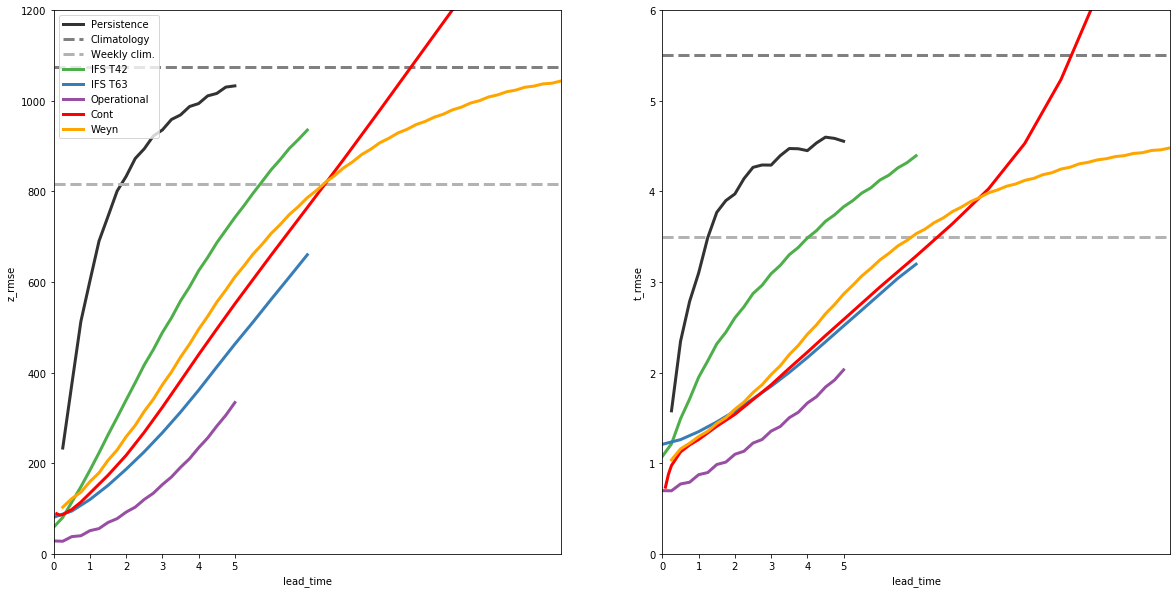

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_rmses(rmses, 'z', ax=ax1)
plot_rmses(rmses, 't', ax=ax2)
# ax1.plot(lead_times, [p.z_rmse for p in preds], lw=3, c='r', label='Rasp')
# ax2.plot(lead_times, [p.t_rmse for p in preds], lw=3, c='r')
scores.z_rmse.plot(ax=ax1, lw=3, c='r', label='Cont')
scores.t_rmse.plot(ax=ax2, lw=3, c='r')
rmse_weyn.z_rmse.plot(ax=ax1, lw=3, c='orange', label='Weyn')
rmse_weyn.t_rmse.plot(ax=ax2, lw=3, c='orange')
for ax in [ax1, ax2]: ax.set_xlim(0, 336)
ax1.legend(loc=2, ncol=1, fontsize=10)

## RMSE

In [14]:
args = load_args('../nn_configs/B/95-resnet_cont_rmse.yml')

In [15]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_rmse': tf.keras.losses.mse})

In [289]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [290]:
args['ext_mean'] = mean
args['ext_std'] = std

In [291]:
args['test_years'] = ['2017', '2017']

In [292]:
dg = load_data(**args, only_test=True)

DG start 10:02:45.205063
DG normalize 10:02:45.241472
DG load 10:02:45.250535
Loading data into RAM
DG done 10:02:49.626501


In [294]:
lead_time = np.concatenate([np.arange(2, 6, 2), np.arange(6, 24, 6), np.arange(24, 120, 12), np.arange(120, 336+1, 24)])

In [295]:
preds = create_cont_predictions(model, dg, lead_time=lead_time)

In [296]:
preds.to_netcdf('./preds_cont_rmse.nc')

In [297]:
preds

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 23, lon: 64, time: 4377)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01T04:00:00 ... 2017-12-31T20:00:00
  * lead_time  (lead_time) int64 2 4 6 12 18 24 36 ... 216 240 264 288 312 336
Data variables:
    t          (lead_time, time, lat, lon) float64 257.4 257.5 257.6 ... nan nan
    z          (lead_time, time, lat, lon) float64 5.089e+04 5.092e+04 ... nan

In [298]:
scores = evaluate_iterative_forecast(preds, valid, compute_weighted_rmse).load(); scores

<xarray.Dataset>
Dimensions:    (lead_time: 23)
Coordinates:
  * lead_time  (lead_time) int64 2 4 6 12 18 24 36 ... 216 240 264 288 312 336
Data variables:
    t_rmse     (lead_time) float64 0.931 1.05 1.167 1.384 ... 4.961 5.483 6.007
    z_rmse     (lead_time) float64 120.2 112.1 115.7 ... 1.087e+03 1.131e+03

In [299]:
scores.to_netcdf('./rmse_cont_rmse.nc')

In [301]:
dg[0][1].shape

(32, 32, 64, 2)

In [ ]:
t

## Check generalization error

In [16]:
args = load_args('../nn_configs/B/91-resnet_cont.yml')

In [17]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})

In [18]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [19]:
args['ext_mean'] = mean
args['ext_std'] = std

In [20]:
args['train_years'] = ['2014', '2014']

In [21]:
dg_train, dg_valid, dg_test = load_data(**args)

In [22]:
dg_train.shuffle = False
dg_train.on_epoch_end()

In [48]:
lead_time = np.concatenate([np.arange(2, 6, 2), np.arange(6, 24, 6), np.arange(24, 120, 12), np.arange(120, 336+1, 24)])

In [23]:
lead_time = np.concatenate([[6], np.arange(24, 121, 24)])

In [50]:
preds_train = create_cont_predictions(model, dg_train, lead_time=lead_time)

In [51]:
preds_valid = create_cont_predictions(model, dg_valid, lead_time=lead_time)

In [25]:
preds_test = create_cont_predictions(model, dg_test, lead_time=np.array([24, 120]))

KeyboardInterrupt: 

In [ ]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [53]:
scores_train = evaluate_iterative_forecast(preds_train, valid, compute_weighted_rmse).load()

In [54]:
scores_valid = evaluate_iterative_forecast(preds_valid, valid, compute_weighted_rmse).load()

In [54]:
scores_test = evaluate_iterative_forecast(preds_teset, valid, compute_weighted_rmse).load()

In [60]:
exp_id = args['exp_id']

In [61]:
preds_train.to_netcdf(f'{args["pred_save_dir"]}/{exp_id}_train.nc')

In [62]:
preds_valid.to_netcdf(f'{args["pred_save_dir"]}/{exp_id}_valid.nc')

In [13]:
scores_train = xr.open_dataset('./rmse_cont_train.nc')

In [15]:
scores_train.load()

<xarray.Dataset>
Dimensions:    (lead_time: 6)
Coordinates:
  * lead_time  (lead_time) int64 6 24 48 72 96 120
Data variables:
    z_rmse     (lead_time) float64 86.39 131.3 202.1 277.2 352.5 451.2
    t_rmse     (lead_time) float64 0.9818 1.258 1.501 1.745 1.99 2.306

In [63]:
scores_train.to_netcdf('./rmse_cont_train.nc')

In [64]:
scores_valid.to_netcdf('./rmse_cont_valid.nc')

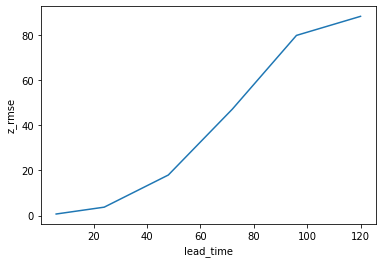

In [66]:
(scores_valid - scores_train).z_rmse.plot()

## Erm, did I do this wrong all along?

In [284]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')

In [285]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_rmse': tf.keras.losses.mse})

ValueError: Unknown loss function:lat_mse

In [ ]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [ ]:
args['ext_mean'] = mean
args['ext_std'] = std

In [ ]:
args['test_years'] = ['2017', '2017']

In [ ]:
args['data_subsample']

In [ ]:
dg = load_data(**args, only_test=True, test_data_subsample=2)

In [115]:
preds = create_predictions(model, dg)

In [116]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t_rmse   float64 1.826
    z_rmse   float64 315.5

In [117]:
dg = load_data(**args, only_test=True, test_data_subsample=1)

DG start 10:21:43.098437
DG normalize 10:21:43.132543
DG load 10:21:43.143283
Loading data into RAM
DG done 10:21:50.287091


In [118]:
preds = create_predictions(model, dg)

In [119]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t_rmse   float64 1.84
    z_rmse   float64 319.9

## Multi-dt training

In [8]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

### Create non mulit reference model

In [21]:
args = load_args('../nn_configs/B/92-resnet_multi_dt.yml')

In [22]:
args['train_years'] = ['2015', '2015']
args['multi_dt'] = 1
args['lead_time'] = 12

In [23]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:16:48.890040
DG normalize 10:16:48.927622
DG load 10:16:53.613641
Loading data into RAM
DG done 10:16:59.094038


In [24]:
X, y = dg_train[0]

In [25]:
len(X), len(y)

(32, 32)

In [26]:
X[0].shape, X[1].shape

((32, 64, 38), (32, 64, 38))

In [27]:
model_ref = build_resnet(
    [64, 64, 35], [7, 3, 3], input_shape=dg_train.shape,
    bn_position=args['bn_position'], use_bias=args['use_bias'], l2=args['l2'], skip=args['skip'],
    dropout=args['dropout'], activation=args['activation']
)

In [28]:
model_ref.compile('adam', 'mse')

In [30]:
model_ref.fit(dg_train, epochs=5, validation_data=dg_valid)

Epoch 1/5
137/137 [==============================] - 12s 89ms/step - loss: 0.1920 - val_loss: 0.2160
Epoch 2/5
137/137 [==============================] - 12s 91ms/step - loss: 0.1852 - val_loss: 0.2056
Epoch 3/5
137/137 [==============================] - 12s 91ms/step - loss: 0.1782 - val_loss: 0.2060
Epoch 4/5
137/137 [==============================] - 12s 90ms/step - loss: 0.1755 - val_loss: 0.1967
Epoch 5/5
137/137 [==============================] - 12s 90ms/step - loss: 0.1728 - val_loss: 0.1964


In [42]:
preds = create_predictions(model_ref, dg_test)

In [43]:
compute_weighted_rmse(preds.z.sel(level=500), valid.z).load()

<xarray.DataArray 'z_rmse' ()>
array(187.15681142)
Coordinates:
    level    int64 500

### Now with the multi-dt model but only supervised for 12

In [50]:
args = load_args('../nn_configs/B/92-resnet_multi_dt.yml')

In [51]:
args['train_years'] = ['2015', '2015']
args['multi_dt'] = 2
args['lead_time'] = 12

In [52]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:34:38.521149
DG normalize 10:34:38.557083
DG load 10:34:42.905827
Loading data into RAM
DG done 10:34:47.811625


In [53]:
X, y = dg_train[0]

In [54]:
len(X), len(y)

(2, 2)

In [60]:
dg_train.cheat = True
dg_valid.cheat = True
dg_test.cheat = True

In [57]:
X, y = dg_train[0]

In [58]:
len(X), len(y)

(2, 32)

In [61]:
def create_multi_dt_model2(model, multi_dt, dg_train):
    const_inp = Input((len(dg_train.data.lat), len(dg_train.data.lon), len(dg_train.const_idxs)))
    x = inp = Input((len(dg_train.data.lat), len(dg_train.data.lon), len(dg_train.not_const_idxs)))
    outputs = []
    for _ in range(multi_dt):
        x = model(Concatenate()([x, const_inp]))
        outputs.append(x)
    model2 = keras.models.Model([inp, const_inp], outputs[-1])
    return model2

In [62]:
model_ref2 = build_resnet(
    [64, 64, 35], [7, 3, 3], input_shape=dg_train.shape,
    bn_position=args['bn_position'], use_bias=args['use_bias'], l2=args['l2'], skip=args['skip'],
    dropout=args['dropout'], activation=args['activation']
)

In [65]:
model2 = create_multi_dt_model2(model_ref2, 2, dg_train)

In [66]:
model2.compile('adam', 'mse')

In [69]:
model2.fit(dg_train, epochs=5, validation_data=dg_valid)

Epoch 1/5
137/137 [==============================] - 22s 162ms/step - loss: 0.1843 - val_loss: 0.2364
Epoch 2/5
137/137 [==============================] - 22s 159ms/step - loss: 0.1826 - val_loss: 0.2320
Epoch 3/5
137/137 [==============================] - 22s 158ms/step - loss: 0.1816 - val_loss: 0.2174
Epoch 4/5
137/137 [==============================] - 22s 157ms/step - loss: 0.1803 - val_loss: 0.2250
Epoch 5/5
137/137 [==============================] - 21s 153ms/step - loss: 0.1786 - val_loss: 0.2274


### now train the continuous model

In [73]:
args = load_args('../nn_configs/B/92-resnet_multi_dt.yml')

In [74]:
args['train_years'] = ['2015', '2015']
args['multi_dt'] = 2
args['lead_time'] = 12

In [75]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:59:18.337236
DG normalize 10:59:18.371865
DG load 10:59:23.725673
Loading data into RAM
DG done 10:59:29.329486


In [76]:
X, y = dg_train[0]

In [77]:
len(X), len(y)

(2, 2)

In [78]:
X[0].shape, X[1].shape

((32, 32, 64, 35), (32, 32, 64, 3))

In [79]:
model_ref3 = build_resnet(
    [64, 64, 35], [7, 3, 3], input_shape=dg_train.shape,
    bn_position=args['bn_position'], use_bias=args['use_bias'], l2=args['l2'], skip=args['skip'],
    dropout=args['dropout'], activation=args['activation']
)

In [80]:
model = create_multi_dt_model(model_ref3, args['multi_dt'], dg_train)

In [81]:
model.compile('adam', 'mse')

In [82]:
model.fit(dg_train, epochs=15, validation_data=dg_valid)

Epoch 1/15
137/137 [==============================] - 24s 173ms/step - loss: 1.4095 - model_6_loss: 0.6636 - model_6_1_loss: 0.7438 - val_loss: 0.6614 - val_model_6_loss: 0.2778 - val_model_6_1_loss: 0.3814
Epoch 2/15
137/137 [==============================] - 23s 167ms/step - loss: 0.6928 - model_6_loss: 0.3081 - model_6_1_loss: 0.3826 - val_loss: 0.5337 - val_model_6_loss: 0.2126 - val_model_6_1_loss: 0.3190
Epoch 3/15
137/137 [==============================] - 23s 167ms/step - loss: 0.5104 - model_6_loss: 0.2200 - model_6_1_loss: 0.2884 - val_loss: 0.5428 - val_model_6_loss: 0.2025 - val_model_6_1_loss: 0.3382
Epoch 4/15
137/137 [==============================] - 23s 164ms/step - loss: 0.4254 - model_6_loss: 0.1790 - model_6_1_loss: 0.2444 - val_loss: 0.4261 - val_model_6_loss: 0.1670 - val_model_6_1_loss: 0.2571
Epoch 5/15
137/137 [==============================] - 23s 166ms/step - loss: 0.3825 - model_6_loss: 0.1580 - model_6_1_loss: 0.2224 - val_loss: 0.4082 - val_model_6_loss: 0

In [70]:
preds = create_predictions(model, dg_test, multi_dt=True)

In [71]:
compute_weighted_rmse(preds.z.sel(level=500), valid.z).load()

<xarray.DataArray 'z_rmse' ()>
array(182.2861689)
Coordinates:
    level    int64 500

### now the model

In [13]:
model = build_resnet(
    [64, 64, 35], [7, 3, 3], input_shape=dg_train.shape,
    bn_position=args['bn_position'], use_bias=args['use_bias'], l2=args['l2'], skip=args['skip'],
    dropout=args['dropout'], activation=args['activation']
)

In [14]:
model = create_multi_dt_model(model, args['multi_dt'], dg_train)

In [15]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 64, 35)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 64, 38)   0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 64, 35)   214051      concatenate[0][0]          

In [16]:
model.compile('adam', 'mse')

In [ ]:
model.fit(dg_train, epochs=5, validation_data=dg_valid)

Train for 274 steps, validate for 138 steps
Epoch 1/5
274/274 [==============================] - 39s 142ms/step - loss: 0.2302 - model_1_loss: 0.0921 - model_1_1_loss: 0.1360 - val_loss: 0.2111 - val_model_1_loss: 0.0829 - val_model_1_1_loss: 0.1263
Epoch 2/5
274/274 [==============================] - 38s 139ms/step - loss: 0.2233 - model_1_loss: 0.0892 - model_1_1_loss: 0.1320 - val_loss: 0.2076 - val_model_1_loss: 0.0811 - val_model_1_1_loss: 0.1245
Epoch 3/5
274/274 [==============================] - 38s 140ms/step - loss: 0.2180 - model_1_loss: 0.0871 - model_1_1_loss: 0.1290 - val_loss: 0.2050 - val_model_1_loss: 0.0797 - val_model_1_1_loss: 0.1233
Epoch 4/5
 55/274 [=====>........................] - ETA: 21s - loss: 0.2154 - model_1_loss: 0.0859 - model_1_1_loss: 0.1274

## Debug C multi run

In [25]:
args = load_args('../nn_configs/C/016-resnet_d3_zt_multi.yml')

KeyError: 'nt'

In [26]:
args['train_years'] = ['2015', '2015']

In [27]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 09:38:37.724437
DG normalize 09:38:37.772396
DG load 09:39:18.201908
Loading data into RAM
DG done 09:39:29.628537


In [43]:
X, y = dg_train[0]

In [44]:
len(X), X[0].shape, X[1].shape

(2, (32, 32, 64, 35), (32, 32, 64, 3))

In [46]:
len(y)

2

In [39]:
dg_train.lead_time = 12

In [41]:
dg_train.multi_dt

2

In [40]:
dg_train.nt

6

In [42]:
6//2

3

## Evaluate trained runs

In [12]:
preds6h = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/014-resnet_d3_zt_6h.nc')
preds12h = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/015-resnet_d3_zt_12h.nc')
predsmulti = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/016-resnet_d3_zt_multi.nc')

In [13]:
def create_predictions_tmp(model, dg, multi_dt=False, parametric=False):
    """Create non-iterative predictions"""
    level_names = dg.data.isel(level=dg.output_idxs).level_names
    level = dg.data.isel(level=dg.output_idxs).level
    if parametric:
        # pdb.set_trace()
        lvl = level_names.values
        mm, ss = [], []
        for l in lvl:
            m = l.split('_'); s = l.split('_')
            m[0] += '-mean'; s[0] += '-std'
            mm.append('_'.join(m)); ss.append('_'.join(s))
        lvl = mm + ss
        level_names = xr.concat([level_names]*2, dim='level')
        level_names[:] = lvl
        level = xr.concat([level]*2, dim='level')

    preds = xr.DataArray(
        model.predict(dg)[1] if multi_dt else model.predict(dg),
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg.valid_time+np.timedelta64(6, 'h'), 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': level,
                'level_names': level_names
                },
    )
    # Unnormalize
    mean = dg.mean.isel(level=dg.output_idxs).values
    std = dg.std.isel(level=dg.output_idxs).values
    if parametric:
        mean = np.concatenate([mean, np.zeros_like(mean)])
        std = np.concatenate([std]*2)
    preds = preds * std + mean

    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    return xr.merge(das)

In [14]:
args = load_args('../nn_configs/C/016-resnet_d3_zt_multi.yml')
model = load_model(args)

In [15]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
dg_test = load_data(**args, only_test=True)

In [21]:
X, y = dg_test[0]

In [22]:
X.shape, y.shape

((32, 32, 64, 38), (32, 32, 64, 35))

In [23]:
model(X)

<tf.Tensor: shape=(32, 32, 64, 35), dtype=float32, numpy=
array([[[[ 0.5136719 , -0.97021484, -0.9692383 , ..., -0.82128906,
          -1.0224609 , -1.0839844 ],
         [ 0.5097656 , -0.97314453, -0.96435547, ..., -0.8154297 ,
          -1.0205078 , -1.0839844 ],
         [ 0.50683594, -0.97314453, -0.95703125, ..., -0.80810547,
          -1.0214844 , -1.0820312 ],
         ...,
         [ 0.53466797, -0.9580078 , -0.97314453, ..., -0.78564453,
          -1.0078125 , -1.0800781 ],
         [ 0.52783203, -0.9633789 , -0.9736328 , ..., -0.7939453 ,
          -1.0107422 , -1.0839844 ],
         [ 0.5205078 , -0.9667969 , -0.97265625, ..., -0.80908203,
          -1.0166016 , -1.0742188 ]],

        [[ 0.47314453, -0.9790039 , -0.9741211 , ..., -0.75683594,
          -0.9814453 , -1.0498047 ],
         [ 0.47314453, -0.9711914 , -0.9404297 , ..., -0.7578125 ,
          -0.99853516, -1.0605469 ],
         [ 0.47558594, -0.9663086 , -0.9213867 , ..., -0.765625  ,
          -1.0263672 , -1.0

In [18]:
predsmulti12 = create_predictions_tmp(model, dg_test, multi_dt=True)

ValueError: different number of dimensions on data and dims: 3 vs 4

In [20]:
%debug

> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(123)_infer_coords_and_dims()
    121         raise ValueError(
    122             "different number of dimensions on data "
--> 123             "and dims: %s vs %s" % (len(shape), len(dims))
    124         )
    125     else:

ipdb> y
*** NameError: name 'y' is not defined
ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(344)__init__()
    342             data = _check_data_shape(data, coords, dims)
    343             data = as_compatible_data(data)
--> 344             coords, dims = _infer_coords_and_dims(data.shape, coords, dims)
    345             variable = Variable(dims, data, attrs, fastpath=True)
    346             indexes = dict(

ipdb> u
> <ipython-input-13-05a1cb6070b5>(23)create_predictions_tmp()
     21         coords={'time': dg.valid_time+np.timedelta64(6, 'h'), 'lat': dg.data.lat, 'lon': dg.data.lon,
     22                 'level': level,
---> 23        

ipdb> q


In [97]:
compute_weighted_rmse(preds6h.z.sel(level=500), valid.z).values

array(77.84564888)

In [99]:
compute_weighted_rmse(preds12h.z.sel(level=500), valid.z).values

array(88.7806319)

In [100]:
compute_weighted_rmse(predsmulti.z.sel(level=500), valid.z).values

array(74.43171158)

In [ ]:
compute_weighted_rmse(predsmulti12.z.sel(level=500), valid.z).values

## Analyze multi-dt run

In [121]:
!ls /home/rasp/data/myWeatherBench/predictions/saved_models/92.1*

/home/rasp/data/myWeatherBench/predictions/saved_models/92.1-resnet_multi_dt.h5
/home/rasp/data/myWeatherBench/predictions/saved_models/92.1-resnet_multi_dt_history.pkl
/home/rasp/data/myWeatherBench/predictions/saved_models/92.1-resnet_multi_dt_mean.nc
/home/rasp/data/myWeatherBench/predictions/saved_models/92.1-resnet_multi_dt_std.nc
/home/rasp/data/myWeatherBench/predictions/saved_models/92.1-resnet_multi_dt_weights.h5


In [76]:
with open('/home/rasp/data/myWeatherBench/predictions/saved_models/92-resnet_multi_dt_history.pkl', 'rb') as f:
    h = pickle.load(f)

In [84]:
h.keys()

dict_keys(['loss', 'model_loss', 'model_1_loss', 'model_mse', 'model_1_mse', 'val_loss', 'val_model_loss', 'val_model_1_loss', 'val_model_mse', 'val_model_1_mse', 'lr'])

In [82]:
h['model_mse'][-1], h['model_1_mse'][-1]

(0.0310029, 0.04279188)

In [85]:
h['val_model_mse'][-1], h['val_model_1_mse'][-1]

(0.02870091, 0.044721734)

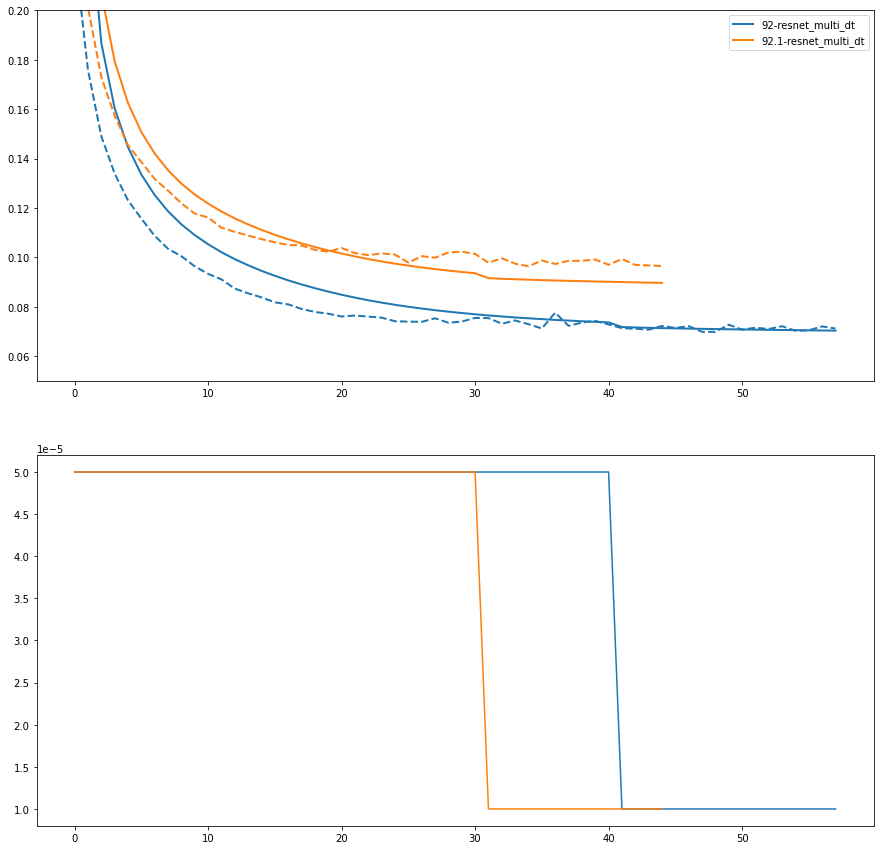

In [122]:
plot_losses('/home/rasp/data/myWeatherBench/predictions/saved_models/', 
            ['92', '92.1'], ylim=(0.05, 0.2)
        )

In [57]:
h = read_pickle('/home/rasp/data/myWeatherBench/predictions/saved_models/92.1-resnet_multi_dt_history.pkl')

In [58]:
h.keys()

dict_keys(['loss', 'model_loss', 'model_1_loss', 'val_loss', 'val_model_loss', 'val_model_1_loss', 'lr'])

(0.0, 0.1)

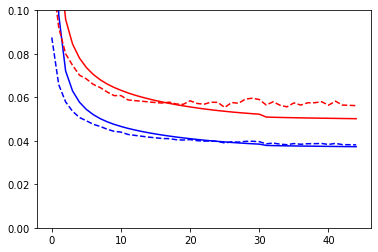

In [62]:
plt.plot(h['model_loss'], c='b')
plt.plot(h['val_model_loss'], c='b', ls='--')
plt.plot(h['model_1_loss'], c='r')
plt.plot(h['val_model_1_loss'], c='r', ls='--')
plt.ylim(0, 0.1)

In [63]:
args = load_args('../nn_configs/B/92-resnet_multi_dt.yml')

In [64]:
args['exp_id'] = '92.1-resnet_multi_dt'

In [65]:
args['train_years'] = ['2015', '2015']

In [66]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [68]:
args['ext_mean'] = mean
args['ext_std'] = std

In [70]:
dg_train, dg_valid, dg_test = load_data(**args)

In [90]:
dg_train.shuffle = False
dg_train.on_epoch_end()

In [99]:
lat_mse = create_lat_mse(valid.lat)

In [100]:
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': lat_mse})

In [101]:
np.min(h['val_loss'])

0.09645969447666321

In [102]:
model.evaluate(dg_train)

137/137 [==============================] - 16s 120ms/step - loss: 0.0923 - model_loss: 0.0366 - model_1_loss: 0.0531


[0.09225141692118052, 0.03656234, 0.053075727]

In [103]:
model.evaluate(dg_valid)

138/138 [==============================] - 13s 96ms/step - loss: 0.0965 - model_loss: 0.0382 - model_1_loss: 0.0556


[0.09645969447666321, 0.038219064, 0.05562728]

In [104]:
model.evaluate(dg_test)

274/274 [==============================] - 26s 94ms/step - loss: 0.0927 - model_loss: 0.0368 - model_1_loss: 0.0533


[0.09272490662053554, 0.036832727, 0.053278834]

In [171]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 64, 35)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 64, 38)   0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 32, 64, 35)   5906979     concatenate[0][0]          

In [172]:
preds = create_predictions(model, dg_test, multi_dt=True)

In [173]:
compute_weighted_rmse(preds.z.sel(level=500), valid.z).load()

<xarray.DataArray 'z_rmse' ()>
array(99.11375851)
Coordinates:
    level    int64 500

In [174]:
compute_weighted_rmse(preds.t.sel(level=850), valid.t).load()

<xarray.DataArray 't_rmse' ()>
array(1.08756775)
Coordinates:
    level    int64 850

#### directly predict 12 hours with net

In [83]:
def create_predictions_tmp(model, dg, multi_dt=False, parametric=False):
    """Create non-iterative predictions"""
    level_names = dg.data.isel(level=dg.output_idxs).level_names
    level = dg.data.isel(level=dg.output_idxs).level
    if parametric:
        # pdb.set_trace()
        lvl = level_names.values
        mm, ss = [], []
        for l in lvl:
            m = l.split('_'); s = l.split('_')
            m[0] += '-mean'; s[0] += '-std'
            mm.append('_'.join(m)); ss.append('_'.join(s))
        lvl = mm + ss
        level_names = xr.concat([level_names]*2, dim='level')
        level_names[:] = lvl
        level = xr.concat([level]*2, dim='level')

    preds = xr.DataArray(
        model.predict(dg)[1] if multi_dt else model.predict(dg),
        dims=['time', 'lat', 'lon', 'level'],
        coords={'time': dg.valid_time+np.timedelta64(6, 'h'), 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': level,
                'level_names': level_names
                },
    )
    # Unnormalize
    mean = dg.mean.isel(level=dg.output_idxs).values
    std = dg.std.isel(level=dg.output_idxs).values
    if parametric:
        mean = np.concatenate([mean, np.zeros_like(mean)])
        std = np.concatenate([std]*2)
    preds = preds * std + mean

    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    return xr.merge(das)

In [84]:
preds12 = create_predictions_tmp(model, dg_test, multi_dt=True)

In [85]:
compute_weighted_rmse(preds12.z.sel(level=500), valid.z).load()

<xarray.DataArray 'z_rmse' ()>
array(166.25113603)
Coordinates:
    level    int64 500

In [86]:
compute_weighted_rmse(preds12.t.sel(level=850), valid.t).load()

<xarray.DataArray 't_rmse' ()>
array(1.38199385)
Coordinates:
    level    int64 850

In [91]:
preds12_train = create_predictions_tmp(model, dg_train, multi_dt=True)

In [92]:
compute_weighted_rmse(preds12_train.z.sel(level=500), valid.z).load()

<xarray.DataArray 'z_rmse' ()>
array(166.69934896)
Coordinates:
    level    int64 500

In [93]:
compute_weighted_rmse(preds12_train.t.sel(level=850), valid.t).load()

<xarray.DataArray 't_rmse' ()>
array(1.38314349)
Coordinates:
    level    int64 850

## Create iterative predictions

In [72]:
max_lead_time = 120

In [74]:
preds_it = create_iterative_precitions(model, dg_test, 120, sample=200)

In [78]:
preds_it_train = create_iterative_precitions(model, dg_train, 120, sample=200)

In [75]:
rmses = evaluate_iterative_forecast(preds_it.z.sel(level=500), z500_valid, compute_weighted_rmse).compute()

In [81]:
rmses_train = evaluate_iterative_forecast(preds_it_train.z.sel(level=500), z500_valid, compute_weighted_rmse).compute()

In [77]:
rmses

<xarray.DataArray 'z_rmse' (lead_time: 20)>
array([ 99.56854984, 164.44412816, 225.17177192, 281.43166445,
       335.6078622 , 387.33419107, 437.51975425, 486.33625531,
       533.96363245, 580.23507027, 625.04730328, 668.17879355,
       710.00844054, 750.3779852 , 789.34173095, 826.73848659,
       862.78271846, 897.45589474, 931.03790106, 963.52652673])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [82]:
rmses_train

<xarray.DataArray 'z_rmse' (lead_time: 20)>
array([  97.97851521,  163.80106247,  225.65741057,  284.05638472,
        340.63098324,  395.3707797 ,  448.44074116,  500.26469778,
        550.60291128,  599.71202019,  647.27627524,  693.49256576,
        738.36186969,  782.13172233,  824.75976398,  865.97036855,
        905.43064979,  942.91569604,  978.4450929 , 1012.08444258])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [225]:
rmse_weyn = xr.open_dataset('./weyn_rmse.nc').load()

In [226]:
rmse_weyn

<xarray.Dataset>
Dimensions:    (lead_time: 56)
Coordinates:
  * lead_time  (lead_time) float64 6.0 12.0 18.0 24.0 ... 324.0 330.0 336.0
Data variables:
    z_rmse     (lead_time) float64 103.2 122.1 136.1 ... 1.039e+03 1.044e+03
    t_rmse     (lead_time) float64 1.038 1.159 1.222 1.295 ... 4.453 4.46 4.48

In [106]:
xr.open_dataset('./rmse_cont.nc').load()

<xarray.Dataset>
Dimensions:    (lead_time: 23)
Coordinates:
  * lead_time  (lead_time) int64 2 4 6 12 18 24 36 ... 216 240 264 288 312 336
Data variables:
    t_rmse     (lead_time) float64 0.7366 0.8798 0.9759 ... 6.167 7.278 8.572
    z_rmse     (lead_time) float64 88.74 85.62 86.75 ... 1.414e+03 1.521e+03

## Create iterative predictions

In [35]:
def create_iterative_precitions(model, dg, max_lead_time, multi_dt=False, sample=None):
    dt = dg.lead_time//dg.multi_dt
    lead_time = np.arange(dt, max_lead_time + dt, dt)
    state = dg.data[:dg.n_samples][:sample, ..., dg.not_const_idxs].values
    consts = dg.data[:dg.n_samples][:sample, ..., dg.const_idxs].values
    preds = []
    for i in tqdm(lead_time):
        if multi_dt:
            p = model.predict([state, consts], batch_size=dg.batch_size)[0]
        else:
            p = model.predict(np.concatenate([state, consts], axis=-1), batch_size=dg.batch_size)
        state = p
        p = p * dg.std.isel(level=dg.output_idxs).values + dg.mean.isel(level=dg.output_idxs).values
        preds.append(p)
    preds = np.array(preds)
    
    preds = xr.DataArray(
        preds,
        dims=['lead_time', 'time', 'lat', 'lon', 'level'],
        coords={'lead_time': lead_time, 'time': dg.init_time[:sample], 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': dg.data.isel(level=dg.output_idxs).level,
                'level_names': dg.data.isel(level=dg.output_idxs).level_names
                },
    )
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))
    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    return xr.merge(das)

In [14]:
args = load_args('../nn_configs/B/115-resnet_small_multi_dt.yml')
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
args['ext_mean'] = mean
args['ext_std'] = std
dg_test = load_data(**args, only_test=True)
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': keras.losses.mse})

In [23]:
preds115 = create_iterative_precitions(model, dg_test, 24, multi_dt=True, sample=200)

In [26]:
evaluate_iterative_forecast(preds115.z.sel(level=500), z500_valid, compute_weighted_rmse).compute()

<xarray.DataArray 'z_rmse' (lead_time: 4)>
array([ 86.25447952, 131.4929319 , 174.52951078, 214.38135172])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24

In [27]:
args = load_args('../nn_configs/B/114-resnet_small_6h_all_out.yml')
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
args['ext_mean'] = mean
args['ext_std'] = std
dg_test = load_data(**args, only_test=True)
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': keras.losses.mse})

In [29]:
model.input

<tf.Tensor 'input_1_2:0' shape=(None, 32, 64, 38) dtype=float32>

In [31]:
dg_test[0][0].shape

(32, 32, 64, 38)

In [36]:
preds114 = create_iterative_precitions(model, dg_test, 24, multi_dt=False, sample=200)

In [37]:
evaluate_iterative_forecast(preds114.z.sel(level=500), z500_valid, compute_weighted_rmse).compute()

<xarray.DataArray 'z_rmse' (lead_time: 4)>
array([ 92.08719593, 151.14842715, 206.69799826, 259.06005596])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24

In [38]:
args = load_args('../nn_configs/B/112-resnet_multi_dt_pre.yml')
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
args['ext_mean'] = mean
args['ext_std'] = std
dg_test = load_data(**args, only_test=True)
model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': keras.losses.mse})

In [39]:
preds112 = create_iterative_precitions(model, dg_test, 24, multi_dt=True, sample=200)

In [41]:
evaluate_iterative_forecast(preds112.z.sel(level=500), z500_valid, compute_weighted_rmse).compute()

<xarray.DataArray 'z_rmse' (lead_time: 4)>
array([104.90710635, 175.40364106, 238.71486332, 295.99065874])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24

## Overfitting test

### Step 1 train direct models for 6, 12 h

In [6]:
args = load_args('../nn_configs/B/92-resnet_multi_dt.yml')

In [7]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't').drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [8]:
args['filters'] = [128, 128, 128, 128, 128, 128, 128, 35]
args['kernels'] = [7, 3, 3, 3, 3, 3, 3, 3]
args['dropout'] = 0

In [9]:
args['exp_id'] = '92.1-resnet_multi_dt'

In [10]:
args['train_years'] = ['2015-01', '2015-01']
args['valid_years'] = ['2015-01', '2015-01']
args['test_years'] = ['2015-01', '2015-01']

In [11]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [12]:
args['ext_mean'] = mean
args['ext_std'] = std

In [13]:
args['multi_dt'] = 1

#### 6h

In [14]:
args['lead_time'] = 6

In [16]:
%%debug 
dg_train, dg_valid, dg_test = load_data(**args)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()



ipdb>  s


--Call--
> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(29)load_data()
     27         return lr
     28 
---> 29 def load_data(var_dict, datadir, cmip, cmip_dir, train_years, valid_years, test_years,
     30               lead_time, batch_size, output_vars, data_subsample, norm_subsample,
     31               nt_in, dt_in, only_test=False, ext_mean=None, ext_std=None, cont_time=False,



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(37)load_data()
     35               min_lead_time=None, tp_log=None, tfr_out=False,
     36               **kwargs):
---> 37     if type(ext_mean) is str: ext_mean = xr.open_dataarray(ext_mean)
     38     if type(ext_std) is str: ext_std = xr.open_dataarray(ext_std)
     39 



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(38)load_data()
     36               **kwargs):
     37     if type(ext_mean) is str: ext_mean = xr.open_dataarray(ext_mean)
---> 38     if type(ext_std) is str: ext_std = xr.open_dataarray(ext_std)
     39 
     40     # Open dataset and create data generators



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(41)load_data()
     39 
     40     # Open dataset and create data generators
---> 41     if cmip:
     42 
     43         # Load vars



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(56)load_data()
     54         ds = ds.rename({'plev': 'level'})
     55     else:
---> 56         ds = xr.merge(
     57             [xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords')
     58              for var in var_dict.keys()],



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(57)load_data()
     55     else:
     56         ds = xr.merge(
---> 57             [xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords')
     58              for var in var_dict.keys()],
     59             fill_value=0  # For the 'tisr' NaNs



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(58)load_data()
     56         ds = xr.merge(
     57             [xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords')
---> 58              for var in var_dict.keys()],
     59             fill_value=0  # For the 'tisr' NaNs
     60         )



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(59)load_data()
     57             [xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords')
     58              for var in var_dict.keys()],
---> 59             fill_value=0  # For the 'tisr' NaNs
     60         )
     61 



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(62)load_data()
     60         )
     61 
---> 62     ds_train = ds.sel(time=slice(*train_years))
     63     ds_valid = ds.sel(time=slice(*valid_years))
     64     ds_test = ds.sel(time=slice(*test_years))



ipdb>  n


> /home/rasp/repositories/myWeatherBench/devlog/src/train.py(63)load_data()
     61 
     62     ds_train = ds.sel(time=slice(*train_years))
---> 63     ds_valid = ds.sel(time=slice(*valid_years))
     64     ds_test = ds.sel(time=slice(*test_years))
     65 



ipdb>  ds_train


<xarray.Dataset>
Dimensions:    (lat: 32, level: 13, lon: 64, time: 744)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
Data variables:
    z          (time, level, lat, lon) float32 dask.array<chunksize=(744, 13, 32, 64), meta=np.ndarray>
    t          (time, level, lat, lon) float32 dask.array<chunksize=(744, 13, 32, 64), meta=np.ndarray>
    u          (time, level, lat, lon) float32 dask.array<chunksize=(744, 13, 32, 64), meta=np.ndarray>
    v          (time, level, lat, lon) float32 dask.array<chunksize=(744, 13, 32, 64), meta=np.ndarray>
    q          (time, level, lat, lon) float32 dask.array<chunksize=(744, 13, 32, 64), meta=np.ndarray>
    orography  (lat, lon) float32 dask.array<chunksize=(32, 64), me

ipdb>  c


DG start 12:05:59.054070
DG normalize 12:05:59.101495
DG load 12:05:59.112081
Loading data into RAM
DG done 12:10:00.071943


In [17]:
X, y = dg_train[0]

In [18]:
X.shape, y.shape

((32, 32, 64, 38), (32, 32, 64, 35))

In [19]:
model6 = build_resnet(
    **args, input_shape=dg_train.shape
)

In [20]:
loss = create_lat_mse(dg_train.data.lat)

In [21]:
opt = keras.optimizers.Adam(5e-5)

In [22]:
model6.compile(opt, loss)

In [23]:
model6.fit(dg_train, epochs=40, validation_data=dg_valid, validation_steps=20,
          validation_freq=10)

Epoch 1/40
12/12 [==============================] - 248s 21s/step - loss: 6.8161
Epoch 2/40
 3/12 [======>.......................] - ETA: 2:13 - loss: 3.4247

KeyboardInterrupt: 

In [26]:
preds = create_predictions(model6, dg_test)

In [29]:
compute_weighted_rmse(valid.z, preds.z.sel(level=500)).load()

<xarray.DataArray 'z_rmse' ()>
array(350.85304649)
Coordinates:
    level    int64 500

#### 12 h

In [31]:
args['lead_time'] = 12

In [32]:
dg_train, dg_valid, dg_test = load_data(**args)

In [33]:
model12 = build_resnet(
    **args, input_shape=dg_train.shape
)

In [34]:
loss = create_lat_mse(dg_train.data.lat)

In [35]:
opt = keras.optimizers.Adam(5e-5)

In [36]:
model12.compile(opt, loss)

In [37]:
model12.fit(dg_train, epochs=40, validation_data=dg_valid, validation_steps=20,
          validation_freq=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 137 steps, validate for 20 steps
Epoch 1/40
137/137 [==============================] - 14s 99ms/step - loss: 1.4389
Epoch 2/40
137/137 [==============================] - 8s 62ms/step - loss: 0.3399
Epoch 3/40
137/137 [==============================] - 9s 62ms/step - loss: 0.2732
Epoch 4/40
137/137 [==============================] - 9s 64ms/step - loss: 0.2413
Epoch 5/40
137/137 [==============================] - 9s 63ms/step - loss: 0.2221
Epoch 6/40
137/137 [==============================] - 9s 64ms/step - loss: 0.2085
Epoch 7/40
137/137 [==============================] - 9s 64ms/step - loss: 0.1983
Epoch 8/40
137/137 [==============================] - 9s 64ms/step - loss: 0.1906
Epoch 9/40
137/137 [==============================] - 9s 64ms/step - loss: 0.1839
Epoch 10/40
137/137 [==============================] - 10s 75ms/step - loss: 0.1786 - val_loss: 0.1965
Epoch 11/40
137/137 [==============================] - 9s 64ms/st

In [39]:
preds = create_predictions(model12, dg_test)

In [40]:
compute_weighted_rmse(valid.z, preds.z.sel(level=500)).load()

<xarray.DataArray 'z_rmse' ()>
array(374.85050434)
Coordinates:
    level    int64 500

### Multi dt model

In [42]:
args['lead_time'] = 12
args['multi_dt'] = 2

In [43]:
dg_train, dg_valid, dg_test = load_data(**args)

In [44]:
model_multi = build_resnet(
    **args, input_shape=dg_train.shape
)

In [47]:
model = create_multi_dt_model(model_multi, args['multi_dt'], dg_train)

In [48]:
loss = create_lat_mse(dg_train.data.lat)

In [49]:
opt = keras.optimizers.Adam(1e-5)

In [51]:
model.compile(opt, loss)

In [52]:
model.fit(dg_train, epochs=40, validation_data=dg_valid, validation_steps=20,
          validation_freq=10)

Train for 137 steps, validate for 20 steps
Epoch 1/40
137/137 [==============================] - 22s 162ms/step - loss: 11.0969 - model_3_loss: 5.1863 - model_3_1_loss: 5.8941
Epoch 2/40
137/137 [==============================] - 15s 109ms/step - loss: 2.0646 - model_3_loss: 1.0248 - model_3_1_loss: 1.0233
Epoch 3/40
137/137 [==============================] - 15s 106ms/step - loss: 1.1684 - model_3_loss: 0.5825 - model_3_1_loss: 0.5694
Epoch 4/40
137/137 [==============================] - 15s 109ms/step - loss: 0.9015 - model_3_loss: 0.4468 - model_3_1_loss: 0.4383
Epoch 5/40
137/137 [==============================] - 14s 105ms/step - loss: 0.7665 - model_3_loss: 0.3772 - model_3_1_loss: 0.3728
Epoch 6/40
137/137 [==============================] - 14s 105ms/step - loss: 0.6832 - model_3_loss: 0.3340 - model_3_1_loss: 0.3327
Epoch 7/40
137/137 [==============================] - 15s 106ms/step - loss: 0.6254 - model_3_loss: 0.3037 - model_3_1_loss: 0.3052
Epoch 8/40
137/137 [============

In [55]:
preds = create_predictions(model, dg_test, multi_dt=True)

In [56]:
compute_weighted_rmse(valid.z, preds.z.sel(level=500)).load()

<xarray.DataArray 'z_rmse' ()>
array(543.13034505)
Coordinates:
    level    int64 500